In [ ]:
#Se instalan las librerías necesarias
!pip install split-folders
!pip install -tensorflow

ERROR: You must give at least one requirement to install (see "pip help install")


In [ ]:
# Se importan las librerias
from google.colab import files
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Flatten, Dense, GlobalAveragePooling2D, Dropout
from keras.applications.resnet50 import ResNet50
from keras import Input, Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import numpy as np
import tensorflow as tf
import os
import zipfile
import matplotlib.pyplot as plt
import random
import signal
import splitfolders
import glob
import shutil
import pandas as pd
from tensorflow.keras.applications import DenseNet121
from sklearn.utils import class_weight
from collections import Counter
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img


In [ ]:
# Se extrae los datos y se guardan en una localización temporal
local_zip = './Dataset_BUSI.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./temp_dataset')
zip_ref.close()

# Se divide los datos en train y test
splitfolders.ratio('./temp_dataset/Dataset_BUSI_with_GT',
                   output="./dataset_split",
                   seed=1337,
                   ratio=(0.80, 0.10, 0.10),
                   group_prefix=None)

Copying files: 1312 files [00:00, 4479.79 files/s]


In [ ]:
# Se eliminan las máscaras
def remove_masks_from_folder(folder):
    mask_files = glob.glob(f"{folder}/**/*_mask.png", recursive=True)
    print(f"Eliminando {len(mask_files)} archivos de máscara...")
    for f in mask_files:
        os.remove(f)

remove_masks_from_folder("/content/dataset_split")

Eliminando 647 archivos de máscara...


In [ ]:
# Se aumentan artificialmente la clase maligna, que es la minoritaria

augmentation_config = {
    'malignant': 3,
    'benign': 0
}

augmenter = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

for class_name, aug_count in augmentation_config.items():
    path = f'./dataset_split/train/{class_name}'
    for fname in os.listdir(path):
        if not fname.endswith(('.png', '.jpg', '.jpeg')) or 'aug' in fname:
            continue
        img = load_img(os.path.join(path, fname))
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)
        prefix = os.path.splitext(fname)[0]
        i = 0
        for batch in augmenter.flow(x, batch_size=1):
            array_to_img(batch[0]).save(os.path.join(path, f"{prefix}_aug{i}.jpg"))
            i += 1
            if i >= aug_count:
                break

In [ ]:
# Se definen los tamaños de las imágenes
input_size_h = 300
input_size_w = 250
num_colors = 3

In [ ]:
# Se crea el generador de imágenes de train con aumentación
train_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range = 30,
      width_shift_range = 0.2,
      height_shift_range = 0.2,
      shear_range = 0.2,
      zoom_range = 0.2,
      horizontal_flip = True,
      fill_mode = 'nearest')


train_generator = train_datagen.flow_from_directory(
        './dataset_split/train/',
        target_size=(input_size_h, input_size_w),
        batch_size=32,
        color_mode="rgb",
        class_mode='binary'
)

# Se crea el generador de imágenes de validación
val_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = val_datagen.flow_from_directory(
        './dataset_split/val/',

        target_size=(input_size_h, input_size_w),
        color_mode='rgb',
        class_mode='binary',
        batch_size=32,
        shuffle=False
)


# Se crea el generador de imágenes de test
test_datagen = ImageDataGenerator(
    rescale = 1/255)

test_generator = test_datagen.flow_from_directory(
        './dataset_split/test/',
        target_size = (input_size_h, input_size_w),
        color_mode = "rgb",
        class_mode = 'binary'
)

Found 1402 images belonging to 2 classes.
Found 63 images belonging to 2 classes.
Found 68 images belonging to 2 classes.


In [ ]:
# Se muestra el número de imágenes por clase después de los generadores y las aumentaciones
print("\n Imágenes por clase tras el split y aumentación:")
for class_name in train_generator.class_indices:
    path = os.path.join('./dataset_split/train/', class_name)
    count = len([f for f in os.listdir(path) if not f.endswith('_mask.png')])
    print(f"{class_name}: {count} imágenes")


📊 Imágenes por clase tras el split y aumentación:
benign: 734 imágenes
malignant: 668 imágenes


In [ ]:
# Se establecen los pesos manualmeente para el desbalanceo
class_weights = {0: 1.0, 1: 2.0}
print("Usando pesos manuales:")
print("Pesos de clases:", class_weights)


Usando pesos manuales:
Pesos de clases: {0: 1.0, 1: 2.0}


In [ ]:
# Se establecen los parámetros del modelo
learning_rates = [0.00001]
epochs_options = [200]
optimizers = {'adam': Adam}
loss_functions = {'crossentropy': 'binary_crossentropy'}
trainable_layers_options = [30]

results = []
histories = {}

input_shape = (input_size_h,
               input_size_w,
               num_colors)

input = Input(shape = input_shape)

# Se construye y se entrena el modelo
for lr in learning_rates:
    for epochs in epochs_options:
        for opt_name, opt_fn in optimizers.items():
            for loss_name, loss_fn in loss_functions.items():
                for num_layers in trainable_layers_options:
                    print(f"\n🔧 Entrenando: lr={lr}, epochs={epochs}, opt={opt_name}, loss={loss_name}, trainable_layers={num_layers}")
                    base_model = DenseNet121(
                        weights = 'imagenet',
                        include_top = False,
                        input_shape = input_shape)
                    base_model.trainable = True
                    for layer in base_model.layers[:-num_layers]:
                        layer.trainable = False
                    output = base_model.output
                    output = GlobalAveragePooling2D()(output)
                    output = Dense(512,
                                  activation = 'relu')(output)
                    output = Dropout(0.5)(output)
                    output = Dense(1,
                                  activation = 'sigmoid')(output)
                    model = Model(inputs = base_model.input,
                                  outputs = output,
                                  name='Dense121_transfer_learning')

                    optimizer = opt_fn(learning_rate=lr)
                    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

                    model.summary()

                    filepath = "models/model-lr{}-ep{}-opt{}-loss{}-layers{}-epoch{{epoch:02d}}.weights.h5".format(lr, epochs, opt_name, loss_name, num_layers) # Changed to str.format
                    model_name = f"models/full_model-lr{lr}-ep{epochs}-opt{opt_name}-loss{loss_name}-layers{num_layers}.h5"

                    tensorboard_callback = TensorBoard(log_dir='logs')

                    # ModelCheckpoint callback
                    checkpoint_callback = ModelCheckpoint(
                        filepath,
                        monitor = 'accuracy',
                        verbose = 1,
                        save_freq = "epoch",
                        save_weights_only = True,
                        save_best_only = True,
                        mode = 'max')

                    # Early Stopping callback
                    early_stopping_callback = EarlyStopping(
                        monitor='val_loss',
                        patience=5,
                        verbose=1,
                        restore_best_weights=True
                    )

                    # ReduceLROnPlateau callback
                    reduce_lr_callback = ReduceLROnPlateau(
                        monitor='val_loss',
                        factor=0.5,
                        patience=5,
                        verbose=1,
                        min_lr=1e-7
                    )

                    history = model.fit(train_generator,
                                        validation_data = validation_generator,
                                        class_weight = class_weights,
                                        epochs=epochs,
                                        callbacks = [early_stopping_callback,reduce_lr_callback,checkpoint_callback],
                                            )


                    model.save(model_name)
                    key = f"lr={lr},ep={epochs},opt={opt_name},loss={loss_name},layers={num_layers}"
                    histories[key] = history
                    results_test = model.evaluate(test_generator)
                    test_loss = results_test[0]
                    test_acc = results_test[1]
                    final_epoch = len(history.history['val_loss']) - 1
                    val_loss = history.history['val_loss'][final_epoch]
                    val_acc = history.history['val_accuracy'][final_epoch]

                    print(f"Test Loss: {test_loss:.4f}")
                    print(f"Test Accuracy: {test_acc:.4f}")
                    print(f"Validation Loss: {val_loss:.4f}")
                    print(f"Validation Accuracy: {val_acc:.4f}")
                    print(results_test)

                    results.append({
                        'optimizer': opt_name,
                        'loss': loss_name,
                        'lr': lr,
                        'epochs': epochs,
                        'trainable_layers': num_layers,
                        'val_accuracy': val_acc,
                        'val_loss': val_loss,
                        'test_accuracy': test_acc,
                        'test_loss': test_loss,
                        'stopped_epoch': len(history.history['val_loss'])
                    })


df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by='val_accuracy', ascending=False)
print("\nResultados ordenados por val_accuracy:")
print(df_results)


🔧 Entrenando: lr=1e-05, epochs=200, opt=adam, loss=crossentropy, trainable_layers=30
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "Dense121_transfer_learning"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 300, 250,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 306, 256,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 150, 125,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 150, 125,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 150, 125,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 152, 127,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 75, 63,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 75, 63,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 75, 63,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 75, 63,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 75, 63,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 75, 63,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 75, 63,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 75, 63,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 75, 63,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 75, 63,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 75, 63,    │     12,288 │ conv2_block2_0_r

 Total params: 7,562,817 (28.85 MB)

 Trainable params: 1,166,721 (4.45 MB)

 Non-trainable params: 6,396,096 (24.40 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5248 - loss: 1.0554
Epoch 1: accuracy improved from -inf to 0.52354, saving model to models/model-lr1e-05-ep200-optadam-losscrossentropy-layers30-epoch01.weights.h5
44/44 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.5248 - loss: 1.0552 - val_accuracy: 0.3810 - val_loss: 0.7371 - learning_rate: 1.0000e-05
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.5301 - loss: 1.0174
Epoch 2: accuracy improved from 0.52354 to 0.55207, saving model to models/model-lr1e-05-ep200-optadam-losscrossentropy-layers30-epoch02.weights.h5
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 615ms/step - accuracy: 0.5306 - loss: 1.0172 - val_accuracy: 0.4762 - val_loss: 0.7064 - learning_rate: 1.0000e-05
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.5793 - loss: 0.9418
Epoch 3: accuracy improved from 0.55207 to 0.56134, saving model to models/model-lr1e-05-ep200-optadam-losscrossentropy-layers30-epoch03.weights.h5
44/44 ━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.8293 - loss: 0.4494
Test Loss: 0.4264
Test Accuracy: 0.8382
Validation Loss: 0.3636
Validation Accuracy: 0.8095
[0.42642998695373535, 0.8382353186607361]

Resultados ordenados por val_accuracy:
  optimizer          loss       lr  epochs  trainable_layers  val_accuracy  \
0      adam  crossentropy  0.00001     200                30      0.809524   

   val_loss  test_accuracy  test_loss  stopped_epoch  
0  0.363618       0.838235    0.42643             42  


In [ ]:
# Se muestran los resultados finales
print("\n=== Final Accuracy Summary ===\n")
for r in results:
    print(f"LR: {r['lr']:<8} | Epochs: {r['epochs']:<2} | Opt: {r['optimizer']:<8} | Loss: {r['loss']:<12} | Layers: {r['trainable_layers']:<2} | Test Accuracy: {r['test_accuracy']:.4f}| Stopped Epoch: {r['stopped_epoch']}")



=== Final Accuracy Summary ===

LR: 1e-05    | Epochs: 200 | Opt: adam     | Loss: crossentropy | Layers: 30 | Test Accuracy: 0.8382| Stopped Epoch: 42


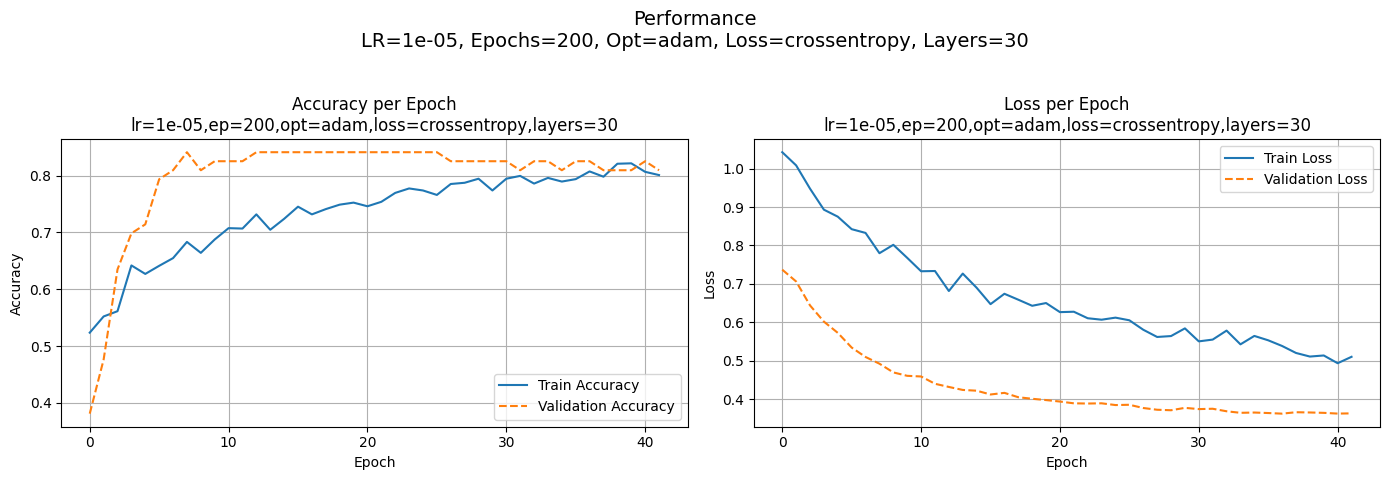

In [ ]:
# Se crean las gráficas de accuracy y loss
for name, history in histories.items():
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy
    axs[0].plot(history.history['accuracy'], label='Train Accuracy')
    axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
    axs[0].set_title(f'Accuracy per Epoch\n{name}')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()
    axs[0].grid(True)

    # Loss
    axs[1].plot(history.history['loss'], label='Train Loss')
    axs[1].plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
    axs[1].set_title(f'Loss per Epoch\n{name}')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    axs[1].grid(True)

    lr = name.split(',')[0].split('=')[1]
    ep = name.split(',')[1].split('=')[1]
    opt = name.split(',')[2].split('=')[1]
    loss = name.split(',')[3].split('=')[1]
    layers = name.split(',')[4].split('=')[1]

    full_title = f"Performance\nLR={lr}, Epochs={ep}, Opt={opt}, Loss={loss}, Layers={layers}"
    plt.suptitle(full_title, fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


📥 Evaluando modelo: models/full_model-lr1e-05-ep200-optadam-losscrossentropy-layers30.h5
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step


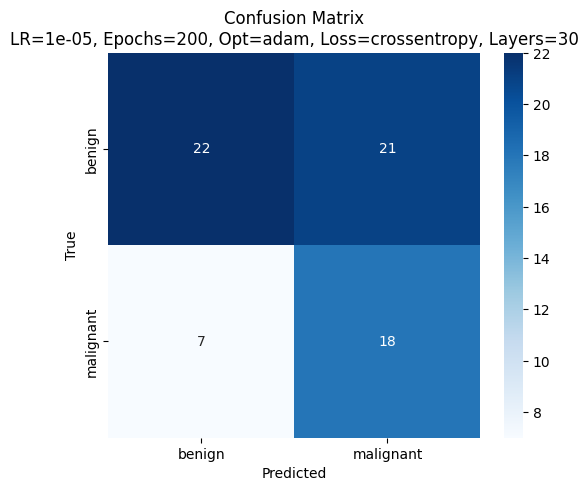

Classification Report:

              precision    recall  f1-score   support

      benign       0.76      0.51      0.61        43
   malignant       0.46      0.72      0.56        25

    accuracy                           0.59        68
   macro avg       0.61      0.62      0.59        68
weighted avg       0.65      0.59      0.59        68



In [ ]:
# Se establece el threshold para generar la matriz de confusión y las distintas métricas de evaluación
threshold = 0.25

for r in results:
    lr = r['lr']
    epochs = r['epochs']
    opt = r['optimizer']
    loss = r['loss']
    layers = r['trainable_layers']
    model_name = f"models/full_model-lr{lr}-ep{epochs}-opt{opt}-loss{loss}-layers{layers}.h5"

    print(f"\n Evaluando modelo: {model_name}")

    tuned_model = load_model(model_name, compile=False)

    y_pred_probs = tuned_model.predict(test_generator)
    y_pred_classes = (y_pred_probs > threshold).astype(int).reshape(-1)

    y_true = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())

    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.title(f"Confusion Matrix\nLR={lr}, Epochs={epochs}, Opt={opt}, Loss={loss}, Layers={layers}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    print("Classification Report:\n")
    print(classification_report(y_true, y_pred_classes, target_names=class_labels))


Total test images: 68



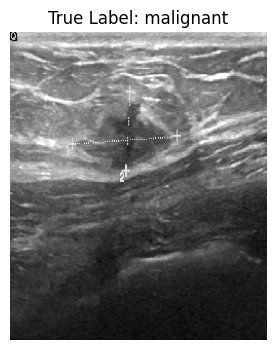

Predicted Label: malignant: 44.39%
----------------------------------------


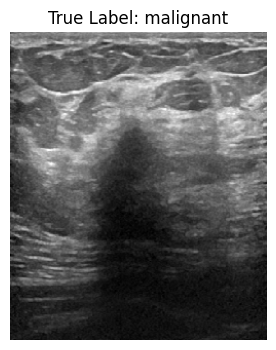

Predicted Label: malignant: 77.67%
----------------------------------------


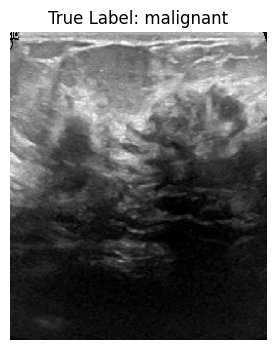

Predicted Label: malignant: 57.46%
----------------------------------------


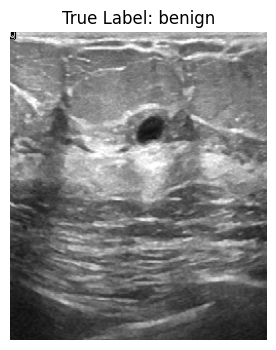

Predicted Label: benign: 98.60%
----------------------------------------


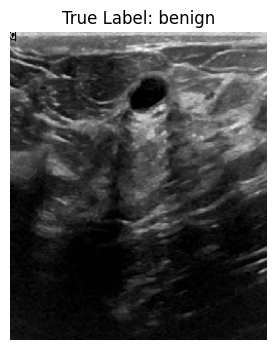

Predicted Label: benign: 98.76%
----------------------------------------


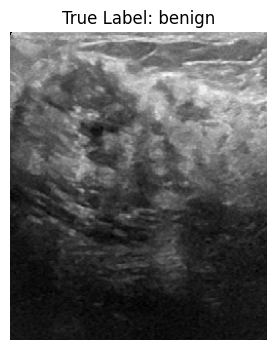

Predicted Label: malignant: 70.23%
----------------------------------------


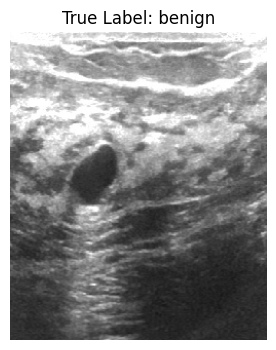

Predicted Label: benign: 98.83%
----------------------------------------


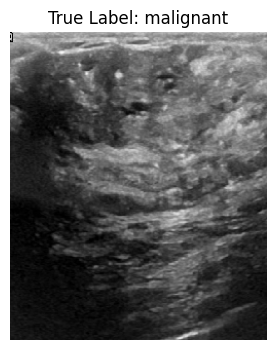

Predicted Label: malignant: 41.69%
----------------------------------------


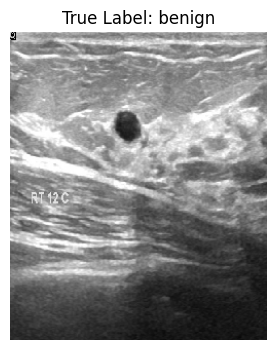

Predicted Label: benign: 99.49%
----------------------------------------


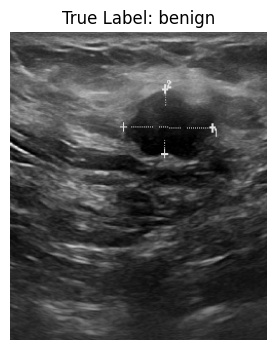

Predicted Label: malignant: 39.39%
----------------------------------------


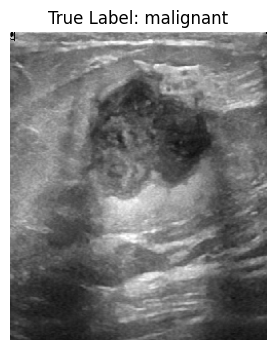

Predicted Label: malignant: 35.69%
----------------------------------------


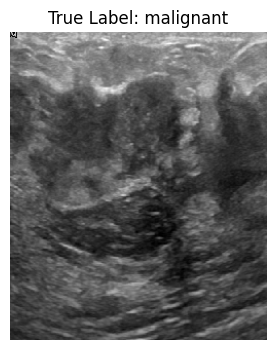

Predicted Label: malignant: 62.30%
----------------------------------------


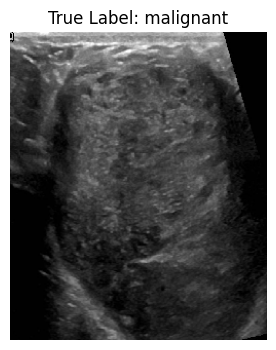

Predicted Label: malignant: 92.66%
----------------------------------------


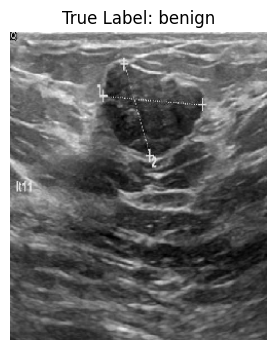

Predicted Label: benign: 92.84%
----------------------------------------


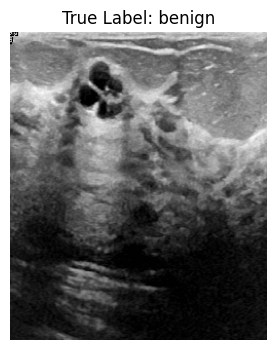

Predicted Label: benign: 99.58%
----------------------------------------


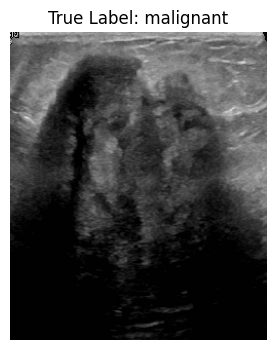

Predicted Label: malignant: 91.98%
----------------------------------------


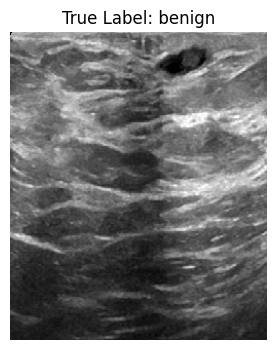

Predicted Label: malignant: 31.44%
----------------------------------------


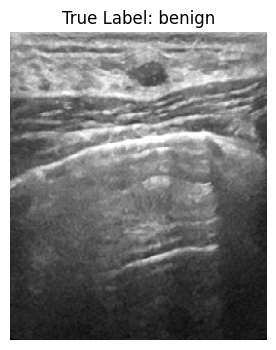

Predicted Label: malignant: 41.44%
----------------------------------------


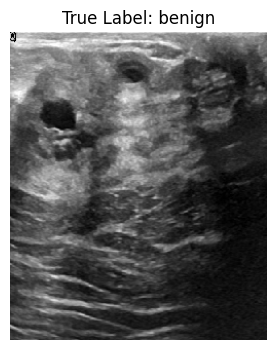

Predicted Label: benign: 97.42%
----------------------------------------


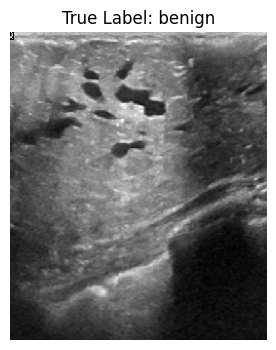

Predicted Label: benign: 77.62%
----------------------------------------


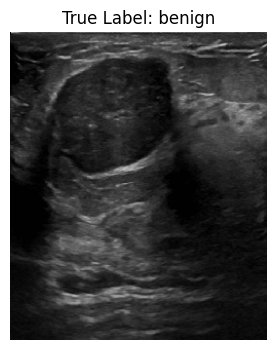

Predicted Label: malignant: 86.32%
----------------------------------------


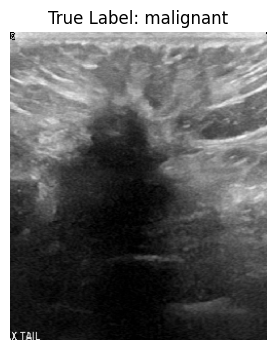

Predicted Label: malignant: 78.31%
----------------------------------------


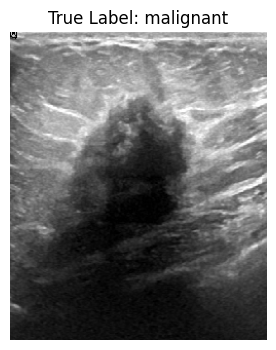

Predicted Label: malignant: 56.29%
----------------------------------------


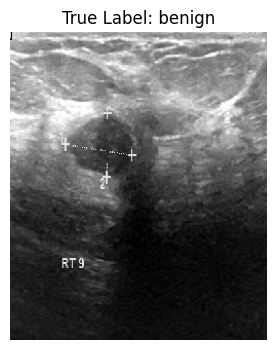

Predicted Label: malignant: 25.98%
----------------------------------------


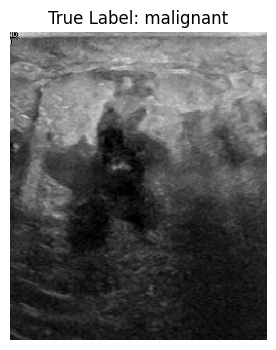

Predicted Label: malignant: 75.77%
----------------------------------------


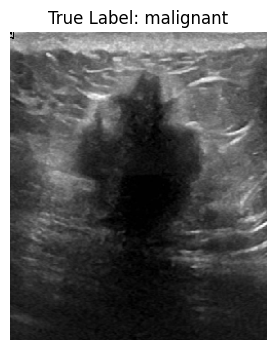

Predicted Label: malignant: 87.92%
----------------------------------------


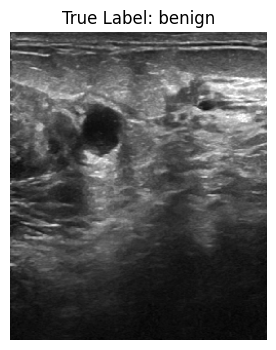

Predicted Label: malignant: 26.56%
----------------------------------------


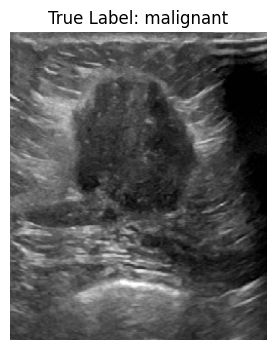

Predicted Label: malignant: 96.76%
----------------------------------------


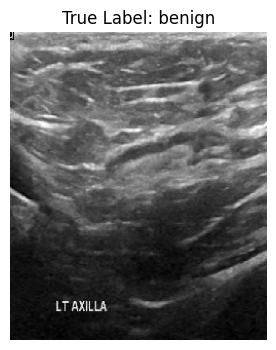

Predicted Label: benign: 87.64%
----------------------------------------


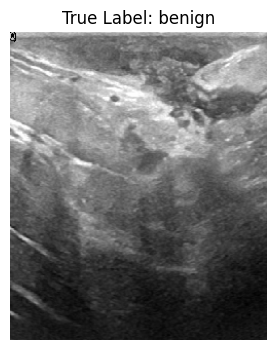

Predicted Label: malignant: 37.60%
----------------------------------------


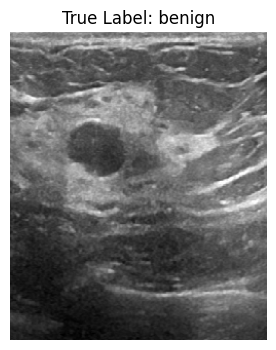

Predicted Label: benign: 76.09%
----------------------------------------


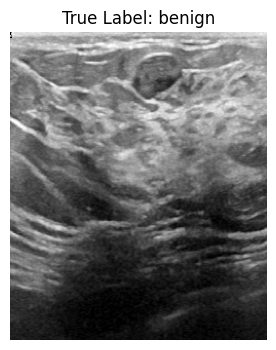

Predicted Label: benign: 90.94%
----------------------------------------


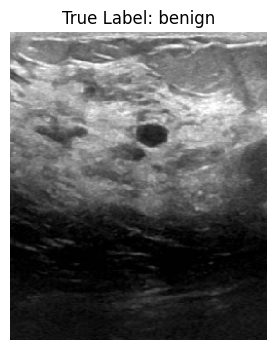

Predicted Label: benign: 97.16%
----------------------------------------


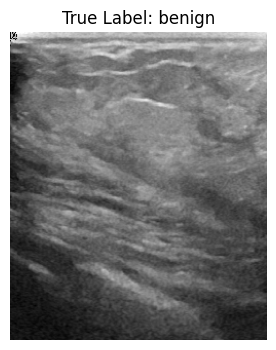

Predicted Label: malignant: 56.49%
----------------------------------------


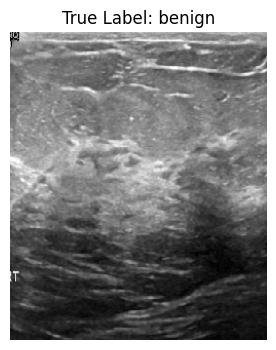

Predicted Label: malignant: 31.62%
----------------------------------------


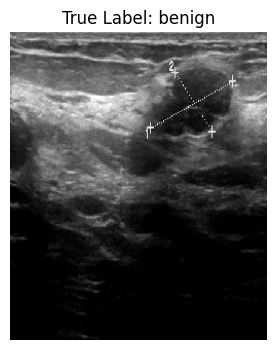

Predicted Label: malignant: 34.47%
----------------------------------------


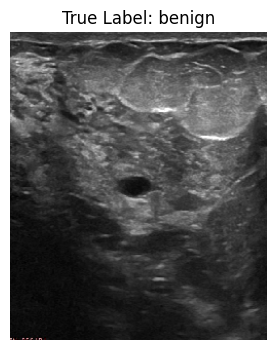

Predicted Label: benign: 89.54%
----------------------------------------


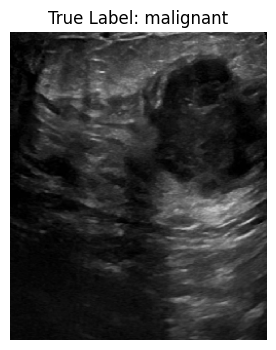

Predicted Label: malignant: 93.84%
----------------------------------------


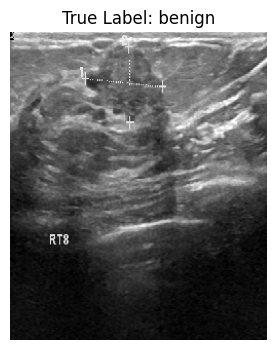

Predicted Label: benign: 91.50%
----------------------------------------


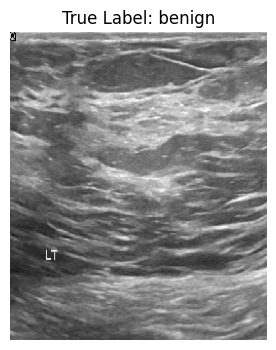

Predicted Label: malignant: 48.95%
----------------------------------------


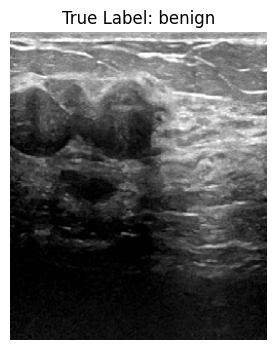

Predicted Label: malignant: 62.95%
----------------------------------------


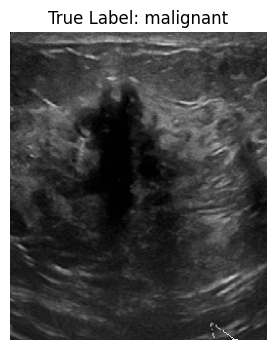

Predicted Label: malignant: 91.88%
----------------------------------------


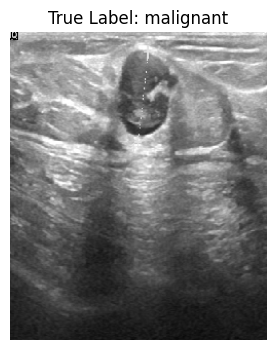

Predicted Label: benign: 99.04%
----------------------------------------


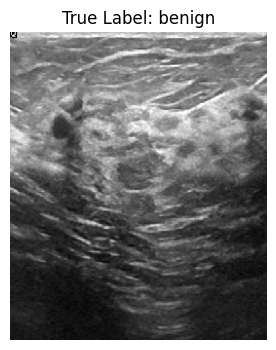

Predicted Label: benign: 87.81%
----------------------------------------


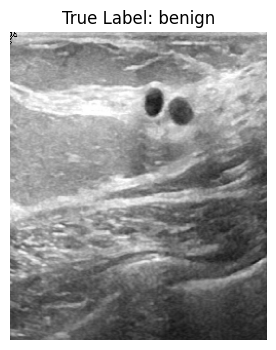

Predicted Label: benign: 99.88%
----------------------------------------


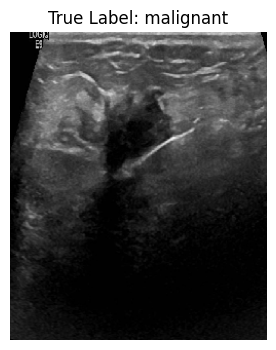

Predicted Label: malignant: 85.91%
----------------------------------------


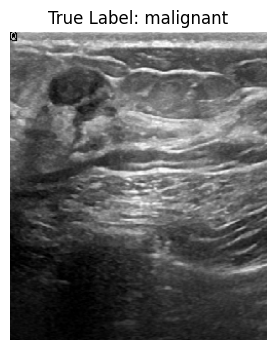

Predicted Label: benign: 93.51%
----------------------------------------


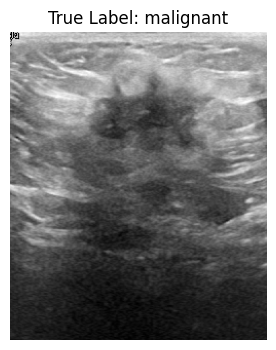

Predicted Label: malignant: 76.18%
----------------------------------------


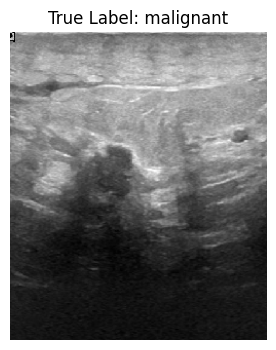

Predicted Label: malignant: 71.02%
----------------------------------------


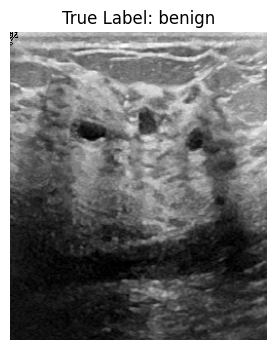

Predicted Label: benign: 95.50%
----------------------------------------


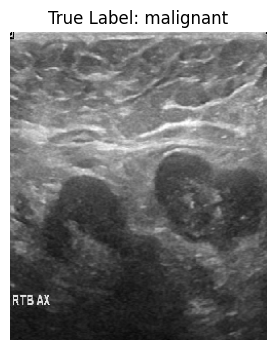

Predicted Label: malignant: 27.00%
----------------------------------------


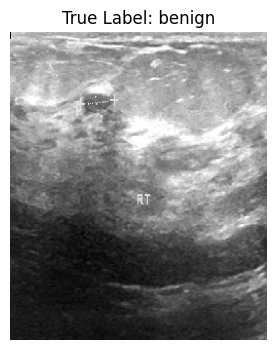

Predicted Label: malignant: 36.29%
----------------------------------------


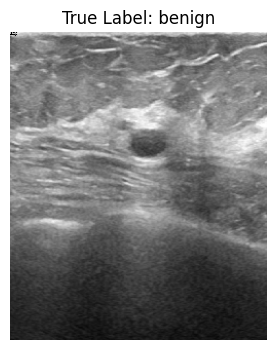

Predicted Label: benign: 82.40%
----------------------------------------


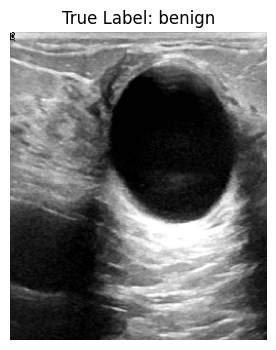

Predicted Label: benign: 99.98%
----------------------------------------


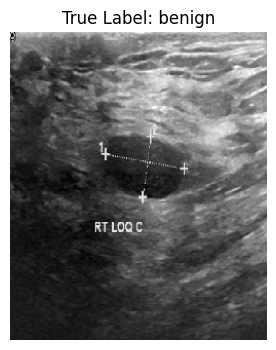

Predicted Label: benign: 88.58%
----------------------------------------


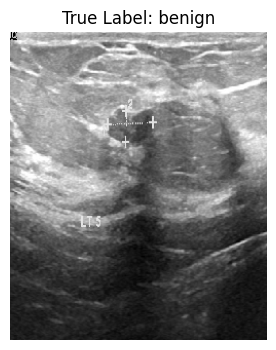

Predicted Label: benign: 84.13%
----------------------------------------


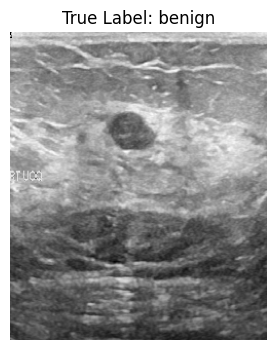

Predicted Label: benign: 94.43%
----------------------------------------


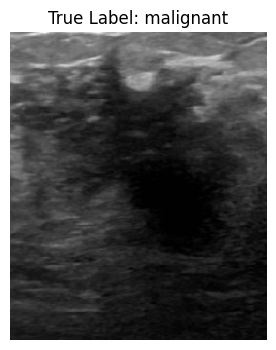

Predicted Label: malignant: 87.13%
----------------------------------------


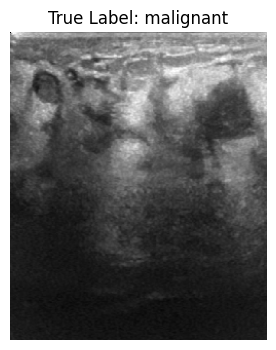

Predicted Label: malignant: 70.80%
----------------------------------------


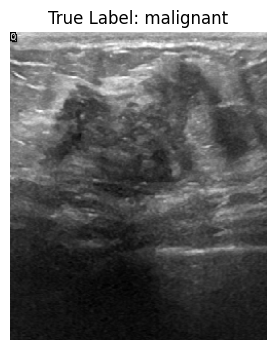

Predicted Label: malignant: 50.28%
----------------------------------------


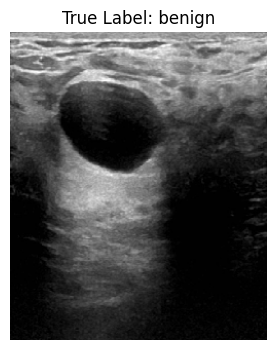

Predicted Label: benign: 99.43%
----------------------------------------


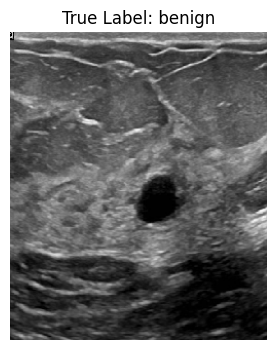

Predicted Label: benign: 99.67%
----------------------------------------


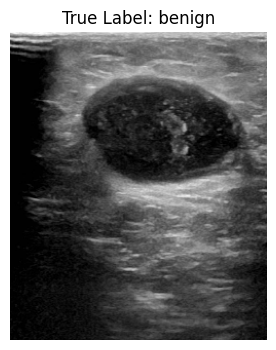

Predicted Label: benign: 98.97%
----------------------------------------


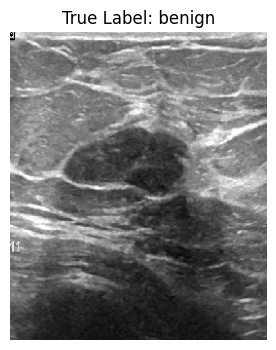

Predicted Label: malignant: 40.44%
----------------------------------------


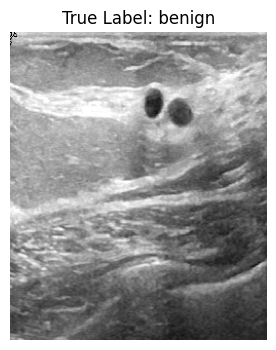

Predicted Label: benign: 99.81%
----------------------------------------


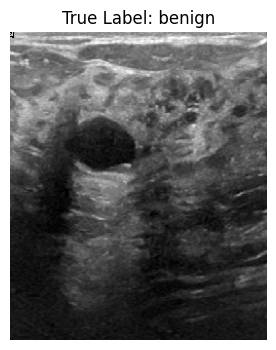

Predicted Label: benign: 95.42%
----------------------------------------


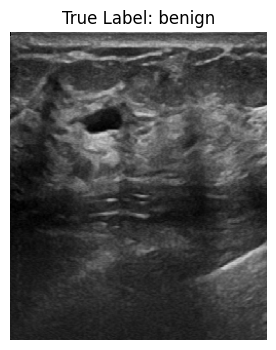

Predicted Label: malignant: 53.76%
----------------------------------------


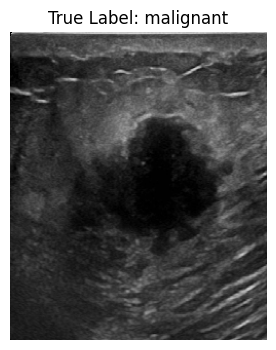

Predicted Label: malignant: 84.22%
----------------------------------------


In [ ]:
# Se muestra la predicción de cada imagen del set de test
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

test_generator.reset()
class_labels = list(test_generator.class_indices.keys())
num_batches = len(test_generator)
total_images = test_generator.samples
print(f"Total test images: {total_images}\n")

counter = 0

for batch_index in range(num_batches):
    img_batch, label_batch = test_generator[batch_index]

    for i in range(len(img_batch)):
        img = img_batch[i]
        label = label_batch[i]

        prediction = model.predict(np.expand_dims(img, axis=0), verbose=0)[0][0]

        predicted_class_index = int(prediction > threshold)
        predicted_label = class_labels[predicted_class_index]
        confidence = prediction if predicted_class_index == 1 else (1 - prediction)

        plt.figure(figsize=(4, 4))
        plt.imshow(img, cmap='gray' if img.shape[-1] == 1 else None)
        plt.axis('off')
        true_label = class_labels[int(label)]
        plt.title(f"True Label: {true_label}")
        plt.show()
        print(f"Predicted Label: {predicted_label}: {confidence*100:.2f}%")
        print("-" * 40)

        counter += 1